# Introduction
In this blog post, I want to show you how you can visualize the contributions of developers to your code base over time. I came across the [Stream Graph visualization](http://leebyron.com/streamgraph/) and it looks like it would fit quite nicely for this purpose. Fortunately, there is already a [D3 template by William Turman](http://bl.ocks.org/WillTurman/4631136) for this that I use in this blog post:

![](resources/steamgraph_example.png)

So let's prototype some visualizations!

# Getting the data
At the beginning, we declare some general variables for easy access and to reuse them for other repositories easily.

In [1]:
PROJECT = "intellij-community"
SOURCE_CODE_FILE_EXTENSION = ".java"
TIME_FREQUENCY = "Q" # how should data be grouped? 'Q' means quarterly

FILENAME_PREFIX = "vis/interactive_streamgraph/"
FILENAME_SUFFIX = "_" + PROJECT + "_" + TIME_FREQUENCY

In this example, I'm using the rather big repository of [IntelliJ](https://github.com/JetBrains/intellij-community) which is written in Java.

We import the existing Git log file with file statistics that was generated using
```bash
git log --numstat --pretty=format:"%x09%x09%x09%h%x09%at%x09%aN" > git_numstat.log
```

In [2]:
import pandas as pd

logfile = "../../{}/git_numstat.log".format(PROJECT)
git_log = pd.read_csv(
    logfile,
    sep="\t", 
    header=None,
    names=[
        'additions', 
        'deletions', 
        'filename', 
        'sha', 
        'timestamp', 
        'author'])
git_log.head()

,additions,deletions,filename,sha,timestamp,author
0,NaN,NaN,NaN,db2987a9533,1.507984e+09,Sergey Simonchik
1,12,3,platform/smRunner/src/com/intellij/execution/t...,NaN,NaN,NaN
2,45,0,platform/smRunner/testSrc/com/intellij/executi...,NaN,NaN,NaN
3,7,6,platform/testRunner/src/com/intellij/execution...,NaN,NaN,NaN
4,9,0,platform/testRunner/src/com/intellij/execution...,NaN,NaN,NaN


The logfile contains the added and deleted lines of code for each file in each commit of an author. 

This file has over 1M entries.

In [3]:
len(git_log)

1025412

The repository itself has over 200k individual commits

In [4]:
git_log['sha'].count()

205799

and almost 400 different contributors (Note: I created a separate `.mailmap` file locally to avoid multiple author names for the same person)

In [5]:
git_log['author'].value_counts().size

371

We mold the raw data to get a nice list of all committed files including additions and deletions by each author. You can find details about this approach in [Reading a Git repo's commit history with Pandas efficiently](https://www.feststelltaste.de/reading-a-git-repos-commit-history-with-pandas-efficiently/).

In [6]:
commits = git_log[['additions', 'deletions', 'filename']]\
    .join(git_log[['sha', 'timestamp', 'author']]\
    .fillna(method='ffill'))\
    .dropna()
commits.head()

,additions,deletions,filename,sha,timestamp,author
1,12,3,platform/smRunner/src/com/intellij/execution/t...,db2987a9533,1.507984e+09,Sergey Simonchik
2,45,0,platform/smRunner/testSrc/com/intellij/executi...,db2987a9533,1.507984e+09,Sergey Simonchik
3,7,6,platform/testRunner/src/com/intellij/execution...,db2987a9533,1.507984e+09,Sergey Simonchik
4,9,0,platform/testRunner/src/com/intellij/execution...,db2987a9533,1.507984e+09,Sergey Simonchik
5,16,3,platform/testRunner/src/com/intellij/execution...,db2987a9533,1.507984e+09,Sergey Simonchik


We further do some basic filtering (because we only want the Java source code) and some data type conversions. Additionally, we calculate a new column that holds the number of `modifications` (added and deleted lines of source code).

In [7]:
commits = commits[commits['filename'].str.endswith(SOURCE_CODE_FILE_EXTENSION)]
commits['additions'] = pd.to_numeric(commits['additions'], errors='coerce').dropna()
commits['deletions'] = pd.to_numeric(commits['deletions'], errors='coerce').dropna()
commits['timestamp'] = pd.to_datetime(commits['timestamp'], unit="s")
commits = commits.set_index(commits['timestamp'])
commits['modifications'] = commits['additions'] + commits['deletions']
commits.head()

,additions,deletions,filename,sha,timestamp,author,modifications
timestamp,,,,,,,
2017-10-14 12:26:59,12.0,3.0,platform/smRunner/src/com/intellij/execution/t...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,15.0
2017-10-14 12:26:59,45.0,0.0,platform/smRunner/testSrc/com/intellij/executi...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,45.0
2017-10-14 12:26:59,7.0,6.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,13.0
2017-10-14 12:26:59,9.0,0.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,9.0
2017-10-14 12:26:59,16.0,3.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,19.0


The next step is optional and some basic data cleaning. It just filters out any nonsense commits that were cause by wrong timestamp configuration of some committers.

In [8]:
commits = commits[commits['timestamp'] <= 'today']
initial_commit_date = commits[-1:]['timestamp'].values[0]
commits = commits[commits['timestamp'] >= initial_commit_date]
commits.head()

,additions,deletions,filename,sha,timestamp,author,modifications
timestamp,,,,,,,
2017-10-14 12:26:59,12.0,3.0,platform/smRunner/src/com/intellij/execution/t...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,15.0
2017-10-14 12:26:59,45.0,0.0,platform/smRunner/testSrc/com/intellij/executi...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,45.0
2017-10-14 12:26:59,7.0,6.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,13.0
2017-10-14 12:26:59,9.0,0.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,9.0
2017-10-14 12:26:59,16.0,3.0,platform/testRunner/src/com/intellij/execution...,db2987a9533,2017-10-14 12:26:59,Sergey Simonchik,19.0


# Summarizing the data
In this section, we group the data to achieve a meaningful visualization with Stream Graphs. We do this by grouping all relevant data of the commits by author and quarters (`TIME_FREQUENCY` is set to `Q` = quarterly). We reset the index because we don't need it in the following.

In [9]:
modifications_over_time = commits[['author', 'timestamp', 'modifications']].groupby(
    [commits['author'], 
     pd.Grouper(freq=TIME_FREQUENCY)]).sum().reset_index()
modifications_over_time.head()

,author,timestamp,modifications
0,(dboulytchev@gmail.com),2012-03-31,126.0
1,Adam Batkin,2015-12-31,2.0
2,Adrian Teng,2014-12-31,10.0
3,Aleksandr Samofalov,2016-03-31,29.0
4,Aleksandr Samofalov,2016-06-30,26.0


We also do some primitive outlier treatment by limiting the number of modifications to lower than the 99% quantile of the whole data.

In [10]:
modifications_over_time['modifications_norm'] = modifications_over_time['modifications'].clip_upper(
    modifications_over_time['modifications'].quantile(0.99))
modifications_over_time[['modifications', 'modifications_norm']].max()

modifications         697744.00
modifications_norm     51262.46
dtype: float64

Next, we pivot the DataFrame to get the modifications for each author over time.

In [11]:
modifications_per_authors_over_time = modifications_over_time.reset_index().pivot_table(
    index=modifications_over_time['timestamp'], 
    columns=modifications_over_time['author'], 
    values='modifications_norm')
modifications_per_authors_over_time.head()

author,(dboulytchev@gmail.com),Adam Batkin,Adrian Teng,Aleksandr Samofalov,Aleksey Pivovarov,Aleksey Rostovskiy,Aleksey Zezukin,Alex Ruiz,Alexander Chernikov,Alexander Doroshko,...,shanavas,shkate,siosio,spLeaner,stsypanov,svloyso,sweinreuter,unknown,vadim.lomshakov,yole
timestamp,,,,,,,,,,,,,,,,,,,,,
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ugly visualization
At this point, we could already plot the data with the built-in `plot` function of Pandas.

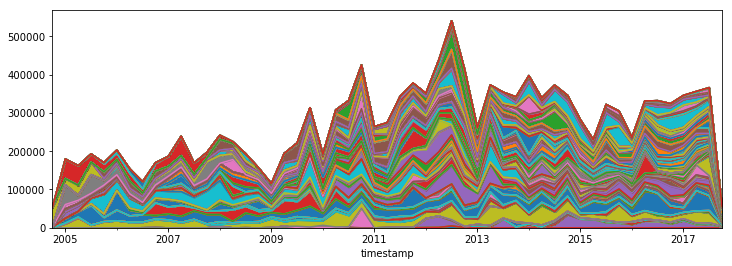

In [12]:
%matplotlib inline
modifications_per_authors_over_time.plot(kind='area', legend=None, figsize=(12,4))

But it doesn't look good at all :-/

Let's bend the data in a way so that it fits into the Stream Graph D3 template!


# Treat missing data
The D3.js template that we are using needs a continuous series of timestamp data for each author. We are filling the existing `modifications_per_authors_over_time` DataFrame with the missing values. That means to add all quarters for all authors by introducing a new `time_range` index.

In [13]:
time_range = pd.DatetimeIndex(
    start=modifications_per_authors_over_time.index.min(),
    end=modifications_per_authors_over_time.index.max(), 
    freq=TIME_FREQUENCY)
time_range

DatetimeIndex(['2004-12-31', '2005-03-31', '2005-06-30', '2005-09-30',
               '2005-12-31', '2006-03-31', '2006-06-30', '2006-09-30',
               '2006-12-31', '2007-03-31', '2007-06-30', '2007-09-30',
               '2007-12-31', '2008-03-31', '2008-06-30', '2008-09-30',
               '2008-12-31', '2009-03-31', '2009-06-30', '2009-09-30',
               '2009-12-31', '2010-03-31', '2010-06-30', '2010-09-30',
               '2010-12-31', '2011-03-31', '2011-06-30', '2011-09-30',
               '2011-12-31', '2012-03-31', '2012-06-30', '2012-09-30',
               '2012-12-31', '2013-03-31', '2013-06-30', '2013-09-30',
               '2013-12-31', '2014-03-31', '2014-06-30', '2014-09-30',
               '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30',
               '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30',
               '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31'],
              dtype='datetime64[ns]', freq='Q-D

To combine the new index with our existing DataFrame, we have to reindex the existing DataFrame and transform the data format.

In [14]:
full_history = pd.DataFrame(
    modifications_per_authors_over_time.reindex(time_range).fillna(0).unstack().reset_index()
)
full_history.head()

,author,level_1,0
0,(dboulytchev@gmail.com),2004-12-31,0.0
1,(dboulytchev@gmail.com),2005-03-31,0.0
2,(dboulytchev@gmail.com),2005-06-30,0.0
3,(dboulytchev@gmail.com),2005-09-30,0.0
4,(dboulytchev@gmail.com),2005-12-31,0.0


Then we adjust the column names and ordering to the given CSV format for the D3 template and export the data into a CSV file.

In [15]:
full_history.columns = ["key", "date", "value"]
full_history = full_history.reindex(columns=["key", "value", "date"])
full_history.to_csv(FILENAME_PREFIX + "modifications" + FILENAME_SUFFIX + ".csv", index=False)
full_history.head()

,key,value,date
0,(dboulytchev@gmail.com),0.0,2004-12-31
1,(dboulytchev@gmail.com),0.0,2005-03-31
2,(dboulytchev@gmail.com),0.0,2005-06-30
3,(dboulytchev@gmail.com),0.0,2005-09-30
4,(dboulytchev@gmail.com),0.0,2005-12-31


Because we use a template in this example, we simply copy it and replace the CSV filename variable with the filename from above.

In [16]:
with open("vis/interactive_streamgraph_template.html", "r") as template:
    content = template.read()
    content = content.replace("${FILENAME}", "modifications" + FILENAME_SUFFIX + ".csv")
    with open(FILENAME_PREFIX + "modifications" + FILENAME_SUFFIX + ".html", "w") as output_file:
        output_file.write(content)

And that's it!

# Result 1: Modifications over time

Here is the Stream Graph for the IntelliJ Community GitHub Project:

![](https://feststelltaste.github.io/software-analytics/notebooks/resources/streamgraph_modifications.jpg)

The visualization is also interactive. You can hover over one color to see a committer's "modifications trail".

![](https://feststelltaste.github.io/software-analytics/notebooks/resources/streamgraph_modifications_highlighted.jpg)

You can find the interactive Stream Graph [here](https://feststelltaste.github.io/software-analytics/notebooks/vis/interactive_streamgraph/modifications_intellij-community_Q.html) (but beware, it loads 0.5 MB of data. This has to be improved in the future).

# Result 2: Committers over time
Another interesting visualization with Stream Graphs is the number of committers over time. With this, you can see how the developer fluctuation in your project was.

To achieve this, we set the number 1 for each committer that has contributed code in a quarter. Because we are <strike>lazy</strike> efficient, we reuse the `value` column for that.

In [17]:
full_history_committers = full_history.copy()
full_history_committers['value'] = full_history_committers['value'].apply(lambda x: min(x,1))
full_history_committers.to_csv(FILENAME_PREFIX + "committer" + FILENAME_SUFFIX + ".csv", index=False)

with open("vis/interactive_streamgraph_template.html", "r") as template:
    content = template.read()
    content = content.replace("${FILENAME}", "committer" + FILENAME_SUFFIX + ".csv")
    with open(FILENAME_PREFIX + "committer" + FILENAME_SUFFIX + ".html", "w") as output_file:
        output_file.write(content)
        
full_history_committers.head()

,key,value,date
0,(dboulytchev@gmail.com),0.0,2004-12-31
1,(dboulytchev@gmail.com),0.0,2005-03-31
2,(dboulytchev@gmail.com),0.0,2005-06-30
3,(dboulytchev@gmail.com),0.0,2005-09-30
4,(dboulytchev@gmail.com),0.0,2005-12-31


Here you can see the results &ndash; the number of active committers over time:

![](https://feststelltaste.github.io/software-analytics/notebooks/resources/streamgraph_committer.jpg)

Again, you can have a look at one committer by hovering over the Stream Graph:

![](https://feststelltaste.github.io/software-analytics/notebooks/resources/streamgraph_committer_highlighted.jpg)

You can find the interactive version of it [here](https://feststelltaste.github.io/software-analytics/notebooks/vis/interactive_streamgraph/committer_intellij-community_Q.html) (again beware, loads 0.5 MB currently).

# Conclusion
Stream Graphs are a good visualization technique for chronological data. The interactive feature of highlighting individual is a nice bonus that enables a more detailed view of the data.

Further optimizations should be made regarding the used template: The data format needs a continuous stream of data that leads to huge data files. Additionally, the color schema is hard-coded but should also be dynamically generated.

Overall, Pandas and the Stream Graph D3 template give you a quick way for visualizing Git repository contributions :-)